<a href="https://colab.research.google.com/github/MitPitt/msu-nn-special-course/blob/main/%D0%97%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Обучение простого варианта модели YOLO (You Only Look Once). 

Требуется обучить модель на основе [Humble Yolo](https://medium.com/@ecaradec/humble-yolo-implementation-in-keras-64d1b63b4412) распознавать два класса объектов на изображении. 

Исходный код модели есть на [GitHub](https://github.com/ecaradec/humble-yolo). Требуется изменить создание синтетических данных так, чтобы вместо  

двух строк использовались два изображения на ваш выбор. Размер, количество и расположение изображений задается случайным образом. 

Результат работы оформите в виде записной книжки Jupyter, в которой должно быть создание синтетических данных, обучение модели и применение модели для обнаружения объектов на тестовых изображениях. 

## Генерация синтетических данных

In [47]:
rooster = Image.open("/content/rooster.png")
chicken = Image.open("/content/chicken.png")

In [48]:
from PIL import Image, ImageDraw
import random
import string
import numpy as np
import os

def one_hot(x, length):
    return [1 if x==i else 0 for i in range(length)]

def get_word(c):
    words = ["chicken", "rooster", "none"]
    return (words[c], one_hot(c,len(words)))

cell_w = 32
cell_h = 32
grid_w = 2
grid_h = 2

if not os.path.exists('Labels'):
    os.mkdir('Labels')
if not os.path.exists('Images'):
    os.mkdir('Images')

for j in range(0,5000):
    img = Image.new('RGB', (grid_w*cell_w,grid_h*cell_h))
    d = ImageDraw.Draw(img)
    
    with open('Labels/%d.txt' % j,'w+') as f:
     
        for row in range(grid_w):
            for col in range(grid_h):

                (digits, cat) = get_word(random.randint(0,2))

                #width = len(digits)*6
                #width = 10
                if digits=="chicken":
                    animal = chicken
                elif digits=="rooster":
                    animal = rooster
                width = animal.size[0]
                height = animal.size[1]
                
                if(digits=='none'):
                    f.write('%d %d %d\n' % (cat[0],cat[1],cat[2]) )        
                    f.write('%d %d %d %d\n' % ( col*cell_w+cell_w/2, row*cell_h+cell_h/2, cell_w, cell_h ))
                    f.write('0\n') # confidence of object
                    #print("None", (col,row), (col*cell_w+cell_w/2, row*cell_h+cell_h/2, cell_w, cell_h), 0)
                else:
                    x = random.randrange(col*cell_w, (col+1)*cell_w)
                    y = random.randrange(row*cell_w, min(67, (row+1)*cell_h))
                    
                    #d.text((x-width/2, y-height/2), digits, fill=(255,255,255))
                    img.paste(animal, (x-width//2, y-height//2))

                    f.write('%d %d %d\n' % (cat[0],cat[1],cat[2]))
                    f.write('%d %d %d %d\n' % (x, y, width, height) )
                    f.write('1\n') # confidence of object
                    #print("Objt", (col,row), (x, y, width, 10), 1)
        
        f.write('---\n')

    img.save('Images/%d.PNG' % j)

## Обучение на синтетических данных

In [49]:
from __future__ import print_function
import keras
import tensorflow as tf
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input, Reshape
from keras.layers import Conv2D, MaxPooling2D

from keras.layers.advanced_activations import LeakyReLU, PReLU

from keras import backend as K
from keras.models import load_model
import numpy as np
import sys
import cv2
import argparse

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import matplotlib.pyplot as plt
import matplotlib.patches as patches


x_train = []
y_train = []

nb_boxes=1
grid_w=2
grid_h=2
cell_w=32
cell_h=32
img_w=grid_w*cell_w
img_h=grid_h*cell_h

#
# Read input image and output prediction
#
def load_image(j):
    img = cv2.imread('Images/%d.PNG' % j)
#    img = cv2.resize(img,(64,64))
    
    x_t = img_to_array(img)

    with open("Labels/%d.txt" % j, "r") as f:
        y_t = []
        for row in range(grid_w):
            for col in range(grid_h):
                c_t = [float(i) for i in f.readline().split()]
                [x, y, w, h] = [float(i) for i in f.readline().split()]        
                conf_t = [float(i) for i in f.readline().split()]                
                elt = []
                elt += c_t
                for b in range(nb_boxes):
                    elt += [x/cell_w, y/cell_h, w/img_w, h/img_h] + conf_t
                y_t.append(elt)
        assert(f.readline()=="---\n")
        
    return [x_t, y_t]

#
# Load all images and append to vector
# 
#for j in range(0, 10):
for j in range(10, 5000):
    [x,y] = load_image(j)
    x_train.append(x)
    y_train.append(y)

x_train = np.array(x_train)
y_train = np.array(y_train)

#
# Define the deep learning network
#

# model 2
i = Input(shape=(img_h,img_w,3))

x = Conv2D(16, (1, 1))(i)
x = Conv2D(32, (3, 3))(x)
x = keras.layers.LeakyReLU(alpha=0.3)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(16, (3, 3))(x)
x = Conv2D(32, (3, 3))(x)
x = keras.layers.LeakyReLU(alpha=0.3)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
#x = Dropout(0.25)(x)

x = Flatten()(x)
x = Dense(256, activation='sigmoid')(x)
x = Dense(grid_w*grid_h*(3+nb_boxes*5), activation='sigmoid')(x)
x = Reshape((grid_w*grid_h,(3+nb_boxes*5)))(x)

model = Model(i, x)

#
# The loss function orient the backpropagation algorithm toward the best direction.
#It does so by outputting a number. The larger the number, the further we are from a correct solution.
#Keras also accept that we output a tensor. In that case it will just sum all the numbers to get a single number.
# 
# y_true is training data
# y_pred is value predicted by the network
def custom_loss(y_true, y_pred):
    # define a grid of offsets
    # [[[ 0.  0.]]
    # [[ 1.  0.]]
    # [[ 0.  1.]]
    # [[ 1.  1.]]]

    #grid = np.array([ [[float(x),float(y)]]*nb_boxes   for y in range(grid_h) for x in range(grid_w)])
    grid = [
      [[tf.cast(x, tf.float32), tf.cast(y, tf.float32)]] * nb_boxes
      for y in range(grid_h)
      for x in range(grid_w)
     ]

    # first three values are classes : cat, rat, and none.
    # However yolo doesn't predict none as a class, none is everything else and is just not predicted
    # so I don't use it in the loss
    y_true_class = y_true[...,0:2]
    y_pred_class = y_pred[...,0:2] 

    # reshape array as a list of grid / grid cells / boxes / of 5 elements
    pred_boxes = K.reshape(y_pred[...,3:], (-1,grid_w*grid_h,nb_boxes,5))
    true_boxes = K.reshape(y_true[...,3:], (-1,grid_w*grid_h,nb_boxes,5))
    
    # sum coordinates of center of boxes with cell offsets.
    # as pred boxes are limited to 0 to 1 range, pred x,y + offset is limited to predicting elements inside a cell
    #y_pred_xy   = pred_boxes[...,0:2] + K.variable(grid)
    y_pred_xy = pred_boxes[..., 0:2] + grid
    # w and h predicted are 0 to 1 with 1 being image size
    y_pred_wh   = pred_boxes[...,2:4]
    # probability that there is something to predict here
    y_pred_conf = pred_boxes[...,4]

    # same as predicate except that we don't need to add an offset, coordinate are already between 0 and cell count
    y_true_xy   = true_boxes[...,0:2]
    # with and height
    y_true_wh   = true_boxes[...,2:4]
    # probability that there is something in that cell. 0 or 1 here as it's a certitude.
    y_true_conf = true_boxes[...,4]

    clss_loss  = K.sum(K.square(y_true_class - y_pred_class), axis=-1)
    xy_loss    = K.sum(K.sum(K.square(y_true_xy - y_pred_xy),axis=-1)*y_true_conf, axis=-1)
    wh_loss    = K.sum(K.sum(K.square(K.sqrt(y_true_wh) - K.sqrt(y_pred_wh)), axis=-1)*y_true_conf, axis=-1)

    # when we add the confidence the box prediction lower in quality but we gain the estimation of the quality of the box
    # however the training is a bit unstable

    # compute the intersection of all boxes at once (the IOU)
    intersect_wh = K.maximum(K.zeros_like(y_pred_wh), (y_pred_wh + y_true_wh)/2 - K.square(y_pred_xy - y_true_xy) )
    intersect_area = intersect_wh[...,0] * intersect_wh[...,1]
    true_area = y_true_wh[...,0] * y_true_wh[...,1]
    pred_area = y_pred_wh[...,0] * y_pred_wh[...,1]
    union_area = pred_area + true_area - intersect_area
    iou = intersect_area / union_area

    conf_loss = K.sum(K.square(y_true_conf*iou - y_pred_conf), axis=-1)

    # final loss function
    d = xy_loss + wh_loss + conf_loss + clss_loss
    
    if False:
        d = tf.Print(d, [d], "loss")
        d = tf.Print(d, [xy_loss], "xy_loss")
        d = tf.Print(d, [wh_loss], "wh_loss")
        d = tf.Print(d, [clss_loss], "clss_loss")
        d = tf.Print(d, [conf_loss], "conf_loss")
    
    return d

model = Model(i, x)

adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss=custom_loss, optimizer=adam) # better

print(model.summary())

#
# Training the network
#

model.fit(x_train, y_train, batch_size=64, epochs=25)
model.save_weights('weights_006.h5')

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 64, 64, 16)        64        
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 62, 62, 32)        4640      
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 29, 29, 16)        4624      
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 27, 27, 32)        464

## Проверка на синтетических данных

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


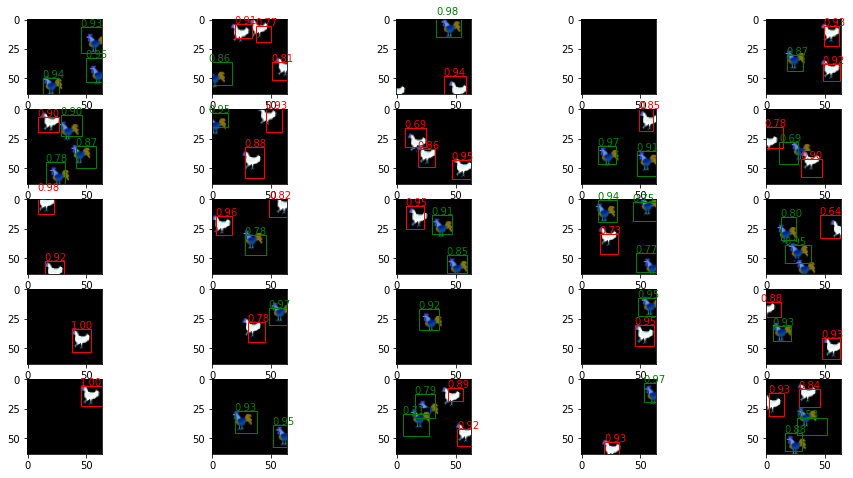

In [52]:
#
# Predict bounding box and classes for the first 25 images
#

plt.figure(figsize=(16,8))

for j in range(0,25):
    #
    # Predict bounding box and classes
    #
    img = cv2.imread('Images/%d.PNG' % j)
    #img = cv2.resize(img, (img_w,img_h))
    #data = img_to_array(img)
    P = model.predict(np.array([ img_to_array(img) ]))
 
    #
    # Draw each boxes and class score over each images using pyplot
    #
    col = 0
    for row in range(grid_w):
        for col in range(grid_h):
            p = P[0][col*grid_h+row]

            boxes = p[3:].reshape(nb_boxes,5)
            clss = np.argmax(p[0:2])
            
            ax = plt.subplot(5,5,j+1)
            imgplot = plt.imshow(img)

            i = 0
            for b in boxes:
                x = b[0]+float(row)
                y = b[1]+float(col)
                w = b[2]
                h = b[3]
                conf = b[4]
                if conf < 0.5:
                    continue

                color = ['r','g','b','0'][clss]
                rect = patches.Rectangle((x*cell_w-w/2*img_w, y*cell_h-h/2*img_h), w*img_h, h*img_h, linewidth=1,edgecolor=color,facecolor='none')
                ax.add_patch(rect)

                ax.text( (x*cell_w-w/2*img_w) / img_w, 1-(y*cell_h-h/2*img_h)/img_h-i*0.15, "%0.2f" % (conf), transform=ax.transAxes, color=color)
                i+=1

plt.show()

## Проверка на тестовых изображениях

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


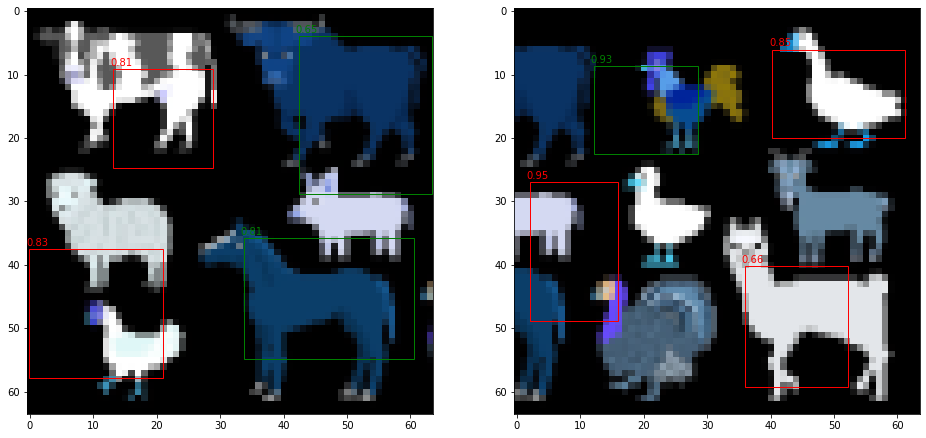

In [59]:
#
# Predict bounding box and classes for the first 25 images
#

plt.figure(figsize=(16,8))

for j in ['animals1.png', 'animals2.png']:
    #
    # Predict bounding box and classes
    #
    img = cv2.imread(j)
    #img = cv2.resize(img, (img_w,img_h))
    #data = img_to_array(img)
    P = model.predict(np.array([ img_to_array(img) ]))
 
    #
    # Draw each boxes and class score over each images using pyplot
    #
    col = 0
    for row in range(grid_w):
        for col in range(grid_h):
            p = P[0][col*grid_h+row]

            boxes = p[3:].reshape(nb_boxes,5)
            clss = np.argmax(p[0:2])
            
            ax = plt.subplot(1,2,int(j[-5]))
            imgplot = plt.imshow(img)

            i = 0
            for b in boxes:
                x = b[0]+float(row)
                y = b[1]+float(col)
                w = b[2]
                h = b[3]
                conf = b[4]
                if conf < 0.5:
                    continue

                color = ['r','g','b','0'][clss]
                rect = patches.Rectangle((x*cell_w-w/2*img_w, y*cell_h-h/2*img_h), w*img_h, h*img_h, linewidth=1,edgecolor=color,facecolor='none')
                ax.add_patch(rect)

                ax.text( (x*cell_w-w/2*img_w) / img_w, 1-(y*cell_h-h/2*img_h)/img_h-i*0.15, "%0.2f" % (conf), transform=ax.transAxes, color=color)
                i+=1

plt.show()

Зверей похожего цвета на петуха и курицу модель сочла за них, что логично, особенно с гусем.